# 문제의 규정 및 본 파일의 구성
## 1) 문제의 규정
- 문제: 본문을 통해 프로젝트의 status를 추측하고 싶다.
- 가설: QA모델로 본문의 특징을 추출했을 때, 어떠한 status를 대표하는 vocabulary가 답변에 많이 나온다면 status를 추측할 수 있다.
- 하위 문제: 각 deal status별로 본문에서 가장 특징적인 vocabulary들을 어떻게 골라낼 것인가?
- 하위 문제 해결 후보 방법:  
1) word counting 후 중복 제거  
2) word appearance 확인 후 중복 제거  
3) 1을 기반으로 회귀분석 / vocab별 가중치에 따라 판단  
4) 1을 기반으로 의사결정나무 구성 / 변수의 중요도에 따라 판단

## 2) 본 파일의 구성
1. Preparations (Word Counting 수행, 라이브러리 등 불러오기)
2. Word Counting 파일 기본 속성 뜯어보기
3. Word Counting 후 중복 제거 (문제 해결 후보 1)
4. Word Appearance로 변환 후 중복 제거 (문제 해결 후보 2)
5. 회귀분석 (문제 해결 후보 3)
6. 의사결정나무 (문제 해결 후보 4)는 투비컨티뉴 ㅎㅎ
7. 결론 및 개선점

# 1. Preparations
## 1) Count the vocabularies
### a. Tokenize the body texts and count each vocabs
#### (private repo) https://github.com/Sensodyne/sdp-vocab-selector.git
- Punctuations and stopwords were removed
- Normalized but not stemmed (소문자로 통일하였으나 단어를 기본형으로 바꾸지 않았음. 시제와 복수형태 등 살림)

## 2) Prepare the environment

In [1]:
# import packages and libraries
import pandas as pd
import numpy as np

# modules to draw charts
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

In [2]:
# environment settings for charts
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # 폰트는 맑은고딕
matplotlib.rcParams['axes.unicode_minus'] = False    # 마이너스 폰트 깨지는 것에 대해
plt.rcParams['figure.figsize'] = (17, 6)

In [3]:
# file path of the tsv file
file_path = 'word_counted.tsv'

In [4]:
# read the input
df = pd.read_csv(file_path, sep='\t')

In [5]:
# word_counted (DataFrame)
df

,deal_status,body_text,word_list,jb,nee,rank,configuration,analysers,grants,competes,...,funneled,lodged,prides,lisa,wants,heal,maclennan,ozkan,modernization,grade
0,operation,Saudi Arabia-headquartered utilities company A...,"['east', 'nation', 'saudi', 'communities', 'ho...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,operation,"Saudi-based Acwa Power, a major developer of p...","['east', 'operating', 'also', 'saudi', 'commun...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,operation,Tata Power has an installed hydro power capaci...,"['hpp', 'gases', 'tata', 'also', 'georgia', 'e...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,operation,The project will generate around 450 GWh of cl...,"['gases', 'hpp', 'exclusively', 'tata', 'georg...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,operation,"Adjaristsqali Georgia (AGL), a joint venture b...","['hpp', 'institutions', 'gases', 'generated', ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,Delayed,Hybrid solar-wind-battery complex in Australia...,"['update', 'become', 'wind', 'ongoing', 'facin...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
873,Delayed,Plans to build the $12 billion Inga 3 hydropow...,"['image', 'de', 'operating', 'become', 'presid...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
874,Delayed,Global Coal Plant Tracker shows project pipeli...,"['highlighted', 'bengal', 'slowed', 'defence',...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
875,Delayed,Floating solar project schedule in Seychelles ...,"['mahe', 'lagoon', 'selected', 'delay', 'news'...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Word Counting 파일 기본 속성 뜯어보기
## deal_status 값 확인

In [6]:
# unique values of the column 'deal_status'
df['deal_status'].unique()

array(['operation', 'Active', 'Cancelled', 'Delayed'], dtype=object)

### a. 'deal_status' == 'operation'

In [7]:
df_operation = df[df['deal_status'] == 'operation']
df_operation

,deal_status,body_text,word_list,jb,nee,rank,configuration,analysers,grants,competes,...,funneled,lodged,prides,lisa,wants,heal,maclennan,ozkan,modernization,grade
0,operation,Saudi Arabia-headquartered utilities company A...,"['east', 'nation', 'saudi', 'communities', 'ho...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,operation,"Saudi-based Acwa Power, a major developer of p...","['east', 'operating', 'also', 'saudi', 'commun...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,operation,Tata Power has an installed hydro power capaci...,"['hpp', 'gases', 'tata', 'also', 'georgia', 'e...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,operation,The project will generate around 450 GWh of cl...,"['gases', 'hpp', 'exclusively', 'tata', 'georg...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,operation,"Adjaristsqali Georgia (AGL), a joint venture b...","['hpp', 'institutions', 'gases', 'generated', ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,operation,This content is for Premium Subscribers only. ...,"['view', 'subscribe', 'subscribers', 'premium'...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
383,operation,"Russia’s new Platov International Airport, whi...","['old', 'airbus', 'places', 'international', '...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,operation,Bohol-Panglao International Airport has starte...,"['image', 'valencia', 'de', 'yet', 'flights', ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
394,operation,The Diplomat. 25/03/2018\n\nThe new terminal b...,"['capacity', 'authority', 'potentials', 'compa...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# the total frequency of appearance (top 100)
operation_sum = df_operation.sum(axis = 0, numeric_only = True)
operation_sum.sort_values(ascending = False, inplace = True)
operation_most_frequent = operation_sum.nlargest(500)
operation_most_frequent_vocab = operation_most_frequent.index.tolist()
"""Uncomment below to check the top 100"""
operation_most_frequent_vocab

['power',
 'energy',
 'project',
 'plant',
 'solar',
 'wind',
 'million',
 'mw',
 'said',
 'company',
 'capacity',
 'airport',
 'new',
 'operation',
 'commercial',
 'construction',
 'first',
 'also',
 'year',
 'operations',
 'electricity',
 'development',
 'per',
 'total',
 'terminal',
 'lng',
 'gas',
 'renewable',
 'expressway',
 'international',
 'projects',
 'one',
 'two',
 'unit',
 'farm',
 'expected',
 'generation',
 'group',
 'years',
 'facility',
 'china',
 'country',
 'located',
 'three',
 'passengers',
 'national',
 'geothermal',
 'us',
 'electric',
 'turbines',
 'market',
 'supply',
 'net',
 'largest',
 'started',
 'system',
 'services',
 'city',
 'local',
 'operating',
 'renewables',
 'may',
 'business',
 'december',
 'investment',
 'around',
 'government',
 'ormat',
 'plants',
 'completed',
 'clean',
 'region',
 'provide',
 'phase',
 'province',
 'south',
 'part',
 'time',
 'service',
 'share',
 'including',
 'announced',
 'adjusted',
 'ge',
 'last',
 'agreement',
 'world',

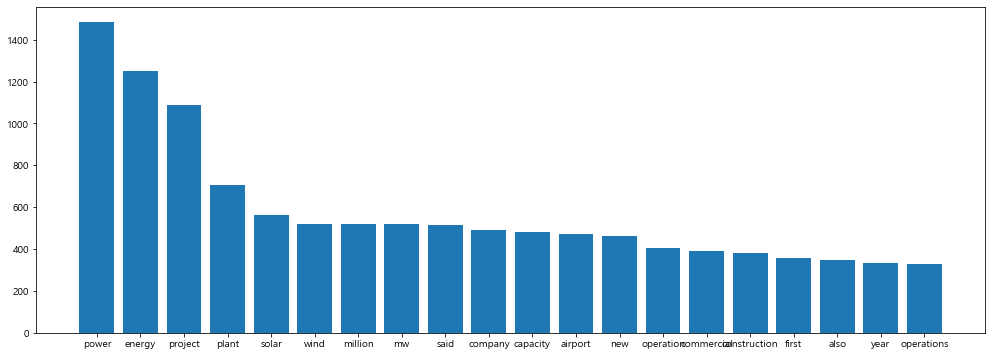

In [9]:
# top 20 graph
y = operation_most_frequent.nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

### b. 'deal_status' == 'Active'

In [10]:
df_active = df[df['deal_status'] == 'Active']
active_sum = df_active.sum(axis = 0, numeric_only = True)
active_sum.sort_values(ascending = False, inplace = True)
active_most_frequent = active_sum.nlargest(500)
active_most_frequent_vocab = active_most_frequent.index.tolist()
"""Uncomment below to check the top 100"""
# active_most_frequent_vocab

'Uncomment below to check the top 100'

### c. 'deal_status' == 'Cancelled'

In [11]:
df_cancelled = df[df['deal_status'] == 'Cancelled']
cancelled_sum = df_cancelled.sum(axis = 0, numeric_only = True)
cancelled_sum.sort_values(ascending = False, inplace = True)
cancelled_most_frequent = cancelled_sum.nlargest(500)
cancelled_most_frequent_vocab = cancelled_most_frequent.index.tolist()
"""Uncomment below to check the top 100"""
# cancelled_most_frequent_vocab

'Uncomment below to check the top 100'

### d. 'deal_status' == 'Delayed'

In [12]:
df_delayed = df[df['deal_status'] == 'Delayed']
delayed_sum = df_delayed.sum(axis = 0, numeric_only = True)
delayed_sum.sort_values(ascending = False, inplace = True)
delayed_most_frequent = delayed_sum.nlargest(500)
delayed_most_frequent_vocab = delayed_most_frequent.index.tolist()
"""Uncomment below to check the top 100"""
# delayed_most_frequent_vocab

'Uncomment below to check the top 100'

In [13]:
overlapped = (set(active_most_frequent_vocab) & set(operation_most_frequent_vocab) &
                  set(cancelled_most_frequent_vocab) & set(delayed_most_frequent_vocab))
overlapped

{'according',
 'added',
 'agreement',
 'airport',
 'along',
 'already',
 'also',
 'announced',
 'another',
 'april',
 'area',
 'around',
 'asia',
 'authority',
 'bank',
 'based',
 'billion',
 'build',
 'building',
 'built',
 'business',
 'capacity',
 'capital',
 'cent',
 'central',
 'china',
 'chinese',
 'city',
 'coal',
 'companies',
 'company',
 'completed',
 'construction',
 'contract',
 'contractor',
 'corporation',
 'cost',
 'costs',
 'could',
 'country',
 'currently',
 'december',
 'demand',
 'design',
 'development',
 'due',
 'economic',
 'electric',
 'electricity',
 'end',
 'energy',
 'engineering',
 'ensure',
 'estimated',
 'existing',
 'expected',
 'february',
 'finance',
 'financial',
 'firm',
 'first',
 'five',
 'following',
 'four',
 'fuel',
 'future',
 'gas',
 'general',
 'generation',
 'global',
 'government',
 'group',
 'high',
 'highway',
 'however',
 'hydropower',
 'impact',
 'include',
 'including',
 'increase',
 'india',
 'industry',
 'information',
 'infrastructure

In [ ]:
# def overlap_for_two(target:list, status1:list, status2:list, status3:list)

# 3. Word Counting 후 중복 제거 (문제 해결 후보 1)

In [14]:
# exclude overlapped ones
operation_indexer = list(set(operation_most_frequent_vocab) - overlapped)
active_indexer = list(set(active_most_frequent_vocab) - overlapped)
cancelled_indexer = list(set(cancelled_most_frequent_vocab) - overlapped)
delayed_indexer = list(set(delayed_most_frequent_vocab) - overlapped)

operation_unique = operation_most_frequent.loc[operation_indexer]
active_unique = active_most_frequent.loc[active_indexer]
cancelled_unique = cancelled_most_frequent.loc[cancelled_indexer]
delayed_unique = delayed_most_frequent.loc[delayed_indexer]

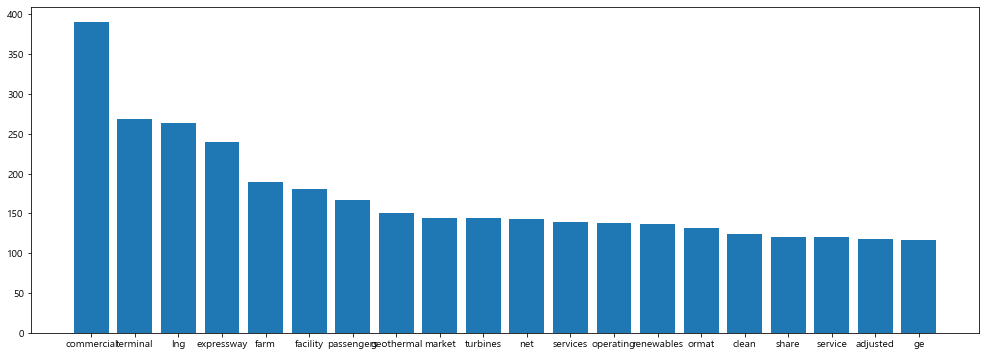

In [15]:
# The top 20s of the unique vocabs in the operation
y = operation_unique.sort_values(ascending = False).nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

In [17]:
len(operation_unique)

310

# 4. Word Appearance로 변환 후 중복 제거 (문제 해결 후보 2)

In [16]:
df_app = df
for col in df.columns:
    if col == 'deal_status' or col == 'body_text' or col == 'word_list':
        continue
    else:
        df_app.loc[df_app[col] > 0, col] = 1
df_app

,deal_status,body_text,word_list,jb,nee,rank,configuration,analysers,grants,competes,...,funneled,lodged,prides,lisa,wants,heal,maclennan,ozkan,modernization,grade
0,operation,Saudi Arabia-headquartered utilities company A...,"['east', 'nation', 'saudi', 'communities', 'ho...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,operation,"Saudi-based Acwa Power, a major developer of p...","['east', 'operating', 'also', 'saudi', 'commun...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,operation,Tata Power has an installed hydro power capaci...,"['hpp', 'gases', 'tata', 'also', 'georgia', 'e...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,operation,The project will generate around 450 GWh of cl...,"['gases', 'hpp', 'exclusively', 'tata', 'georg...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,operation,"Adjaristsqali Georgia (AGL), a joint venture b...","['hpp', 'institutions', 'gases', 'generated', ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,Delayed,Hybrid solar-wind-battery complex in Australia...,"['update', 'become', 'wind', 'ongoing', 'facin...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
873,Delayed,Plans to build the $12 billion Inga 3 hydropow...,"['image', 'de', 'operating', 'become', 'presid...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
874,Delayed,Global Coal Plant Tracker shows project pipeli...,"['highlighted', 'bengal', 'slowed', 'defence',...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
875,Delayed,Floating solar project schedule in Seychelles ...,"['mahe', 'lagoon', 'selected', 'delay', 'news'...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Check if the conversion worked well
df_app.max()

deal_status                                              operation
body_text        ‘Military tactics are like water, for water in...
word_list        ['ørsted', 'current', 'change', 'economically'...
jb                                                               1
nee                                                              1
                                       ...                        
heal                                                             1
maclennan                                                        1
ozkan                                                            1
modernization                                                    1
grade                                                            1
Length: 18286, dtype: object

In [18]:
# function to calculate the frequency
def return_frequency(input_df:pd.DataFrame, column:str, status:str, n:int):
    df_by_status = input_df[input_df[column] == status]
    app_sum = df_by_status.sum(axis = 0, numeric_only = True)
    most_frequent = app_sum.nlargest(n)
    most_frequent_vocab = most_frequent.index.tolist()
    return most_frequent, most_frequent_vocab

In [19]:
app_operation_frequency, app_operation_vocab = return_frequency(df_app, 'deal_status', 'operation', 100)
app_active_frequency, app_active_vocab = return_frequency(df_app, 'deal_status', 'active', 100)
app_cancelled_frequency, app_cancelled_vocab = return_frequency(df_app, 'deal_status', 'Cancelled', 100)
app_delayed_frequency, app_delayed_vocab = return_frequency(df_app, 'deal_status', 'Delayed', 100)

In [20]:
# exclude overlapped ones
# app_overlapped = (set(app_operation_vocab) & set(app_active_vocab) &
#                   set(app_cancelled_vocab) & set(app_delayed_vocab))
app_overlapped = (set(app_cancelled_vocab) & set(app_delayed_vocab) & set(app_operation_vocab))

app_operation_indexer = list(set(app_operation_vocab) - app_overlapped)
app_active_indexer = list(set(app_active_vocab) - app_overlapped)
app_cancelled_indexer = list(set(app_cancelled_vocab) - app_overlapped)
app_delayed_indexer = list(set(app_delayed_vocab) - app_overlapped)

app_operation_unique = app_operation_frequency.loc[app_operation_indexer]
app_active_unique = app_active_frequency.loc[app_active_indexer]
app_cancelled_unique = app_cancelled_frequency.loc[app_cancelled_indexer]
app_delayed_unique = app_delayed_frequency.loc[app_delayed_indexer]

- operation & active 사이 overlapped 없음 / active와 cancelled, active와 delayed 사이 overlapped는 'report' only
- active만 혼자서 단어군이 매우 튀는 것을 확인할 수 있음
- 따라서, overlap되는 단어들은 active만 제외하고 나머지를 &연산을 함.

In [21]:
app_overlapped

{'according',
 'also',
 'capacity',
 'company',
 'completed',
 'construction',
 'cost',
 'country',
 'development',
 'electricity',
 'energy',
 'expected',
 'first',
 'government',
 'including',
 'infrastructure',
 'international',
 'last',
 'local',
 'may',
 'million',
 'national',
 'new',
 'one',
 'part',
 'per',
 'plant',
 'power',
 'project',
 'projects',
 'said',
 'state',
 'three',
 'time',
 'total',
 'two',
 'year',
 'years'}

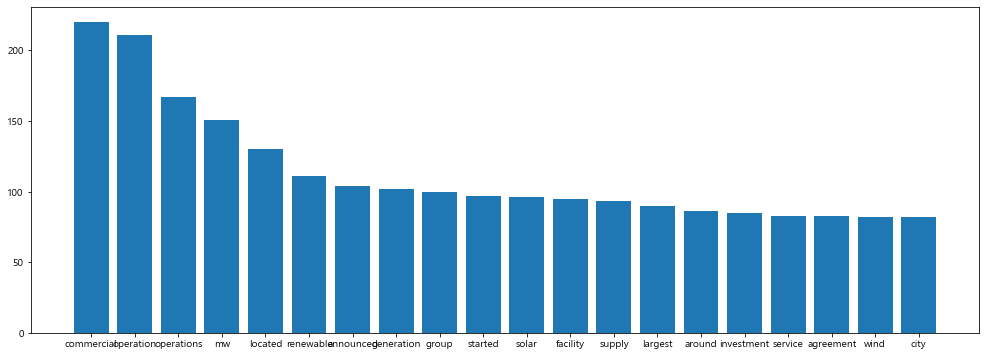

In [22]:
y = app_operation_unique.sort_values(ascending = False).nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

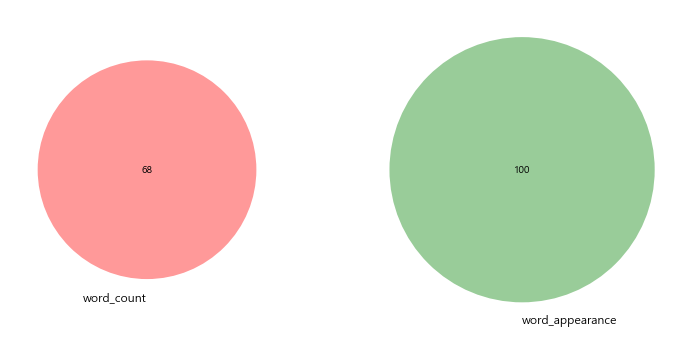

In [23]:
active = set(active_unique.index)
app_active = set(app_active_unique.index)
venn2([active, app_active], set_labels = ('word_count', 'word_appearance'))
plt.show()

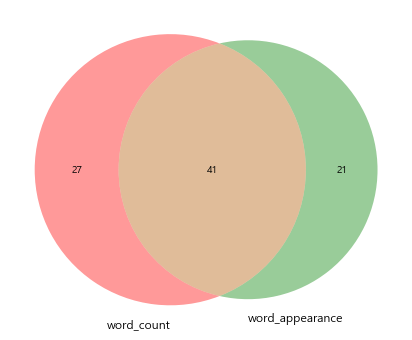

In [24]:
operation = set(operation_unique.index)
app_operation = set(app_operation_unique.index)
venn2([operation, app_operation], set_labels = ('word_count', 'word_appearance'))
plt.show()

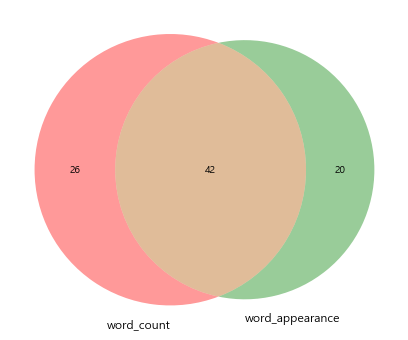

In [25]:
cancelled = set(cancelled_unique.index)
app_cancelled = set(app_cancelled_unique.index)
venn2([cancelled, app_cancelled], set_labels = ('word_count', 'word_appearance'))
plt.show()

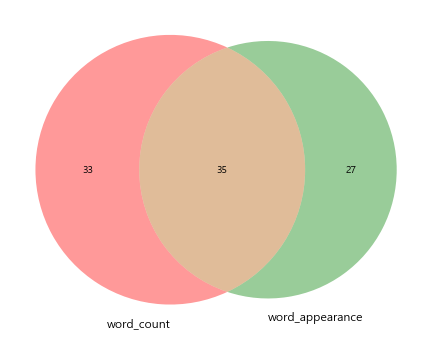

In [26]:
delayed = set(delayed_unique.index)
app_delayed = set(app_delayed_unique.index)
venn2([delayed, app_delayed], set_labels = ('word_count', 'word_appearance'))
plt.show()

# 5. 회귀분석 (문제 해결 후보 3)
- 로지스틱 회귀분석을 실시하였음. (종속변수(Y)와 독립변수(X) 간의 관계를 나태내어 예측모델을 생성한다는 점에서 선형회귀 분석과 비슷하지만, 종속변수(Y)의 결과가 범주형으로 분류 분석에 해당)
- 종속변수는 각 status일 것이고(범주형) / 독립변수는 각 단어들의 출현 빈도 (연속형)
- 로지스틱 회귀 분석은 종속변수(Y)에 로짓 변환을 실시. 위 로지스틱 모형식은 독립변수(X)의 값에 관계 없이 종속변수(Y)의 값이 항상 0 - 1 사이에 있도록 하는 것.
- https://myjamong.tistory.com/80 참고함

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

In [28]:
df_reg = df
df_reg['deal_status'] = pd.Categorical(df_reg['deal_status'])
df_reg

,deal_status,body_text,word_list,jb,nee,rank,configuration,analysers,grants,competes,...,funneled,lodged,prides,lisa,wants,heal,maclennan,ozkan,modernization,grade
0,operation,Saudi Arabia-headquartered utilities company A...,"['east', 'nation', 'saudi', 'communities', 'ho...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,operation,"Saudi-based Acwa Power, a major developer of p...","['east', 'operating', 'also', 'saudi', 'commun...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,operation,Tata Power has an installed hydro power capaci...,"['hpp', 'gases', 'tata', 'also', 'georgia', 'e...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,operation,The project will generate around 450 GWh of cl...,"['gases', 'hpp', 'exclusively', 'tata', 'georg...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,operation,"Adjaristsqali Georgia (AGL), a joint venture b...","['hpp', 'institutions', 'gases', 'generated', ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,Delayed,Hybrid solar-wind-battery complex in Australia...,"['update', 'become', 'wind', 'ongoing', 'facin...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
873,Delayed,Plans to build the $12 billion Inga 3 hydropow...,"['image', 'de', 'operating', 'become', 'presid...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
874,Delayed,Global Coal Plant Tracker shows project pipeli...,"['highlighted', 'bengal', 'slowed', 'defence',...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
875,Delayed,Floating solar project schedule in Seychelles ...,"['mahe', 'lagoon', 'selected', 'delay', 'news'...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df_reg['deal_status_code'] = df_reg.deal_status.cat.codes
df_reg

,deal_status,body_text,word_list,jb,nee,rank,configuration,analysers,grants,competes,...,lodged,prides,lisa,wants,heal,maclennan,ozkan,modernization,grade,deal_status_code
0,operation,Saudi Arabia-headquartered utilities company A...,"['east', 'nation', 'saudi', 'communities', 'ho...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,operation,"Saudi-based Acwa Power, a major developer of p...","['east', 'operating', 'also', 'saudi', 'commun...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,operation,Tata Power has an installed hydro power capaci...,"['hpp', 'gases', 'tata', 'also', 'georgia', 'e...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,operation,The project will generate around 450 GWh of cl...,"['gases', 'hpp', 'exclusively', 'tata', 'georg...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,operation,"Adjaristsqali Georgia (AGL), a joint venture b...","['hpp', 'institutions', 'gases', 'generated', ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,Delayed,Hybrid solar-wind-battery complex in Australia...,"['update', 'become', 'wind', 'ongoing', 'facin...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
873,Delayed,Plans to build the $12 billion Inga 3 hydropow...,"['image', 'de', 'operating', 'become', 'presid...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
874,Delayed,Global Coal Plant Tracker shows project pipeli...,"['highlighted', 'bengal', 'slowed', 'defence',...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
875,Delayed,Floating solar project schedule in Seychelles ...,"['mahe', 'lagoon', 'selected', 'delay', 'news'...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [35]:
new_col = df.columns.tolist()
del new_col[new_col.index('deal_status_code')]
new_col.insert(1, 'deal_status_code')
new_col

['deal_status',
 'deal_status_code',
 'body_text',
 'word_list',
 'jb',
 'nee',
 'rank',
 'configuration',
 'analysers',
 'grants',
 'competes',
 'authorise',
 'termination',
 'button',
 'denies',
 'kajima',
 'shell',
 'tc',
 'vst',
 'greco',
 'slhp',
 'settings',
 'pickering',
 'section',
 'allegation',
 'counterproductive',
 'farruggio',
 'worksite',
 'phasing',
 'ajk',
 'hydraulics',
 'axens',
 'kilometre',
 'gauge',
 'maturity',
 'legal',
 'farmland',
 'cargolux',
 'oppose',
 'turkana',
 'compassion',
 'rahmon',
 'conservator',
 'endorsing',
 'ritual',
 'anju',
 'whether',
 'medog',
 'azima',
 'jostle',
 'cent',
 'spending',
 'show',
 'eia',
 'thermax',
 'patil',
 'semco',
 'auspices',
 'thunderstorm',
 'structures',
 'zambezi',
 'outweighed',
 'fire',
 'report',
 'stealing',
 'taxes',
 'po',
 'interesting',
 'et',
 'ecuador',
 'kmp',
 'torn',
 'tara',
 'monuments',
 'dmtcl',
 'prohibitively',
 'bridges',
 'penh',
 'tickets',
 'unsurpassed',
 'retailer',
 'injustices',
 'stgs',
 'm

In [36]:
df_reg = df_reg[new_col]
df_reg

,deal_status,deal_status_code,body_text,word_list,jb,nee,rank,configuration,analysers,grants,...,funneled,lodged,prides,lisa,wants,heal,maclennan,ozkan,modernization,grade
0,operation,3,Saudi Arabia-headquartered utilities company A...,"['east', 'nation', 'saudi', 'communities', 'ho...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,operation,3,"Saudi-based Acwa Power, a major developer of p...","['east', 'operating', 'also', 'saudi', 'commun...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,operation,3,Tata Power has an installed hydro power capaci...,"['hpp', 'gases', 'tata', 'also', 'georgia', 'e...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,operation,3,The project will generate around 450 GWh of cl...,"['gases', 'hpp', 'exclusively', 'tata', 'georg...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,operation,3,"Adjaristsqali Georgia (AGL), a joint venture b...","['hpp', 'institutions', 'gases', 'generated', ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,Delayed,2,Hybrid solar-wind-battery complex in Australia...,"['update', 'become', 'wind', 'ongoing', 'facin...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
873,Delayed,2,Plans to build the $12 billion Inga 3 hydropow...,"['image', 'de', 'operating', 'become', 'presid...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
874,Delayed,2,Global Coal Plant Tracker shows project pipeli...,"['highlighted', 'bengal', 'slowed', 'defence',...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
875,Delayed,2,Floating solar project schedule in Seychelles ...,"['mahe', 'lagoon', 'selected', 'delay', 'news'...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# seperate independent variable & dependent variable

x = df_reg.loc[:, 'jb':'grade']
y = df_reg['deal_status_code']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))


657
220
657
220


In [38]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

x2 = sm.add_constant(x)
model = sm.OLS(y, x2)
result = model.fit()
print(result.summary())

y_pred = log_reg.predict(x_test)
print(y_pred)
print(list(y_test))

print('정확도 :', metrics.accuracy_score(y_test, y_pred))

                            OLS Regression Results                            
Dep. Variable:       deal_status_code   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     1.339
Date:                Sat, 29 Aug 2020   Prob (F-statistic):              0.306
Time:                        16:14:47   Log-Likelihood:                 579.36
No. Observations:                 877   AIC:                             573.3
Df Residuals:                      11   BIC:                             4710.
Df Model:                         865                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

 3 3 1 3 3 0 3 0 0 3 3 0 3 0 3 0 3 2 3 0 3 0 0 0 0 0 3 2 3 0 3 2 2 3 3]
[3, 3, 3, 0, 3, 0, 1, 3, 2, 0, 2, 0, 2, 2, 0, 0, 3, 0, 1, 2, 0, 3, 3, 3, 2, 0, 1, 3, 2, 3, 1, 3, 0, 0, 2, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 0, 2, 3, 3, 1, 1, 1, 2, 2, 2, 0, 2, 3, 1, 1, 3, 3, 1, 2, 3, 3, 3, 0, 3, 2, 1, 0, 3, 3, 0, 0, 0, 1, 3, 2, 3, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 1, 0, 2, 2, 3, 1, 0, 0, 3, 2, 3, 0, 0, 0, 2, 0, 3, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 0, 0, 2, 3, 3, 0, 2, 1, 0, 1, 3, 3, 3, 3, 0, 1, 3, 3, 1, 3, 0, 3, 1, 0, 3, 2, 3, 2, 1, 3, 0, 1, 3, 1, 3, 0, 2, 3, 3, 0, 3, 3, 3, 0, 0, 0, 2, 1, 3, 0, 2, 0, 1, 0, 3, 3, 3, 2, 0, 3, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 2, 1, 2, 3, 0, 3, 2, 0, 2, 3, 2, 3, 3, 0, 1, 0, 0, 0, 0, 3, 2, 3, 0, 3, 2, 2, 3, 2]
정확도 : 0.8363636363636363


In [39]:
type(result)

statsmodels.regression.linear_model.RegressionResultsWrapper

- p-value는, 귀무가설(null hypothesis, H0)이 맞다는 전제 하에, 통계값(statistics)1이 실제로 관측된 값 이상일 확률을 의미
- p-value가 작은 단어들을 보면, const(0.003), jb(0.158), authorise(0.116), settings (0.095), stabilise(0.112)...? 머지...
- multicollinearity problems가 의심되므로 서로 연관 있는 단어를 삭제하여야 함.

# 6. 의사결정나무 (문제 해결 후보 4)

# 7. 결론 및 개선점

In [41]:
from wordcloud import WordCloud

In [44]:
op_list = operation_unique.index.tolist()

In [52]:
op_tup = []
for e in op_list:
    temp = e, operation_unique.loc[e]
    op_tup.append(temp)
op_tup

[('business', 137),
 ('completed', 124),
 ('provide', 123),
 ('area', 107),
 ('corporation', 110),
 ('supply', 143),
 ('announced', 118),
 ('increase', 110),
 ('operational', 107),
 ('located', 173),
 ('ge', 117),
 ('ormat', 132),
 ('group', 183),
 ('mw', 518),
 ('started', 142),
 ('renewables', 137),
 ('service', 120),
 ('duke', 109),
 ('income', 112),
 ('golar', 106),
 ('operation', 407),
 ('lng', 263),
 ('services', 139),
 ('around', 132),
 ('nuclear', 107),
 ('may', 137),
 ('solar', 563),
 ('part', 121),
 ('texas', 113),
 ('wind', 522),
 ('turbines', 144),
 ('system', 140),
 ('generation', 185),
 ('adjusted', 118),
 ('commercial', 390),
 ('net', 143),
 ('south', 122),
 ('agreement', 115),
 ('approximately', 107),
 ('station', 106),
 ('phase', 123),
 ('december', 136),
 ('plants', 129),
 ('facility', 181),
 ('vietnam', 111),
 ('geothermal', 151),
 ('operating', 138),
 ('market', 144),
 ('share', 120),
 ('us', 148),
 ('including', 119),
 ('expressway', 240),
 ('province', 122),
 ('to

In [53]:
# 히히 워드클라우드 만드는중
wc = WordCloud()
WordCloud.generate_from_frequencies(dict(op_tup))

TypeError: generate_from_frequencies() missing 1 required positional argument: 'frequencies'